<a href="https://colab.research.google.com/github/GiX7000/deep-learning-with-pytorch/blob/main/learn-pytorch-for-deep-learning-in-a-day/Part07_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PyTorch Transfer Learning**

We'll see how by using a powerful technique called [**transfer learning**](https://developers.google.com/machine-learning/glossary#transfer-learning).

## What is transfer learning?

**Transfer learning** allows us to take the patterns (also called weights) another model has learned from another problem and use them for our own problem.

For example, we can take the patterns a computer vision model has learned from datasets such as [ImageNet](https://www.image-net.org/) (millions of images of different objects) and use them to power our FoodVision Mini model.

Or we could take the patterns from a [language model](https://developers.google.com/machine-learning/glossary#masked-language-model) (a model that's been through large amounts of text to learn a representation of language) and use them as the basis of a model to classify different text samples.

## Why use transfer learning?

There are two main benefits to using transfer learning:

1. Can leverage an existing model (usually a neural network architecture) proven to work on problems similar to our own.
2. Can leverage a working model which has **already learned** patterns on similar data to our own. This often results in achieving **great results with less custom data**.




## Where to find pretrained models

There are several places you can find pretrained models to use for your own problems.

| **Location** | **What's there?** | **Link(s)** |
| ----- | ----- | ----- |
| **PyTorch domain libraries** | Each of the PyTorch domain libraries (`torchvision`, `torchtext`) come with pretrained models of some form. The models there work right within PyTorch. | [`torchvision.models`](https://pytorch.org/vision/stable/models.html), [`torchtext.models`](https://pytorch.org/text/main/models.html), [`torchaudio.models`](https://pytorch.org/audio/stable/models.html), [`torchrec.models`](https://pytorch.org/torchrec/torchrec.models.html) |
| **HuggingFace Hub** | A series of pretrained models on many different domains (vision, text, audio and more) from organizations around the world. There's plenty of different datasets too. | https://huggingface.co/models, https://huggingface.co/datasets |
| **`timm` (PyTorch Image Models) library** | Almost all of the latest and greatest computer vision models in PyTorch code as well as plenty of other helpful computer vision features. | https://github.com/rwightman/pytorch-image-models|
| **Paperswithcode** | A collection of the latest state-of-the-art machine learning papers with code implementations attached. You can also find benchmarks here of model performance on different tasks. | https://paperswithcode.com/ |




*With access to such high-quality resources as above, it should be common practice at the start of every deep learning problem you take on to ask, "Does a pretrained model exist for my problem?"*

## What we're going to cover

We're going to take a pretrained model from `torchvision.models` and customise it to work on (and hopefully improve) our FoodVision Mini problem.

| **Topic** | **Contents** |
| ----- | ----- |
| **0. Getting setup** | We've written a fair bit of useful code over the past few sections, let's download it and make sure we can use it again. |
| **1. Get data** | Let's get the pizza, steak and sushi image classification dataset we've been using to try and improve our model's results. |
| **2. Create Datasets and DataLoaders** | We'll use the `data_setup.py` script we wrote in chapter 05. PyTorch Going Modular to setup our DataLoaders. |
| **3. Get and customise a pretrained model** | Here we'll download a pretrained model from `torchvision.models` and customise it to our own problem. |
| **4. Train model** | Let's see how the new pretrained model goes on our pizza, steak, sushi dataset. We'll use the training functions we created in the previous chapter. |
| **5. Evaluate the model by plotting loss curves** | How did our first transfer learning model go? Did it overfit or underfit?  |
| **6. Make predictions on images from the test set** | It's one thing to check out a model's evaluation metrics but it's another thing to view its predictions on test samples, let's *visualize, visualize, visualize*! |

## 0. Getting setup

To save time from writing extra code, we're going to be leveraging some of the Python scripts (such as `data_setup.py` and `engine.py`) we created in the previous section.

Specifically, we're going to download the [`going_modular`](https://github.com/GiX7000/deep-learning-with-pytorch/tree/main/learn-pytorch-for-deep-learning-in-a-day/going_modular) directory.

We'll also get the [`torchinfo`](https://github.com/TylerYep/torchinfo) package if it's not available.

`torchinfo` will help later on to give us a visual representation of our model.

In [1]:
# regular imports
import torch
import torchvision
import matplotlib.pyplot as plt

print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/GiX7000/deep-learning-with-pytorch.git
    !mv /content/deep-learning-with-pytorch/learn-pytorch-for-deep-learning-in-a-day/going_modular . # move the repo to the current working dir
    !rm -rf deep-learning-with-pytorch # remove all extra files we don't need at the working dir
    from going_modular import data_setup, engine

torch version: 2.5.0+cu121
torchvision version: 0.20.0+cu121


In [2]:
# Setup device agnostic code, while you activate first gpu as runtime type
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# check what gpu we use
!nvidia-smi

Sun Oct 27 04:09:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P8              13W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 1. Get data

Before we can start to use **transfer learning**, we'll need a dataset.

To see how transfer learning compares to our previous attempts at model building, we'll download the same dataset we've been using in the previous notebook.

Let's write some code to download the [`pizza_steak_sushi.zip`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi.zip) dataset from the course GitHub and then unzip it.

We can also make sure if we've already got the data, it doesn't redownload.

In [4]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

data/pizza_steak_sushi directory exists.


In [5]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## 2. Create Datasets and DataLoaders

Since we've downloaded the `going_modular` directory, we can use the data_setup.py script we created in section to prepare and setup our DataLoaders.

But since we'll be using a pretrained model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html), there's a specific transform we need to prepare our images first and there are 2 ways to do it: manually and automatically.

### 2.1 Creating a transform for `torchvision.models` (manual creation)

When using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

> All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224.
>
> The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.
>
> You can use the following transform to normalize:
>
> ```
> normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
>                                  std=[0.229, 0.224, 0.225])
> ```

The good news is, we can achieve the above transformations with a combination of:

| **Transform number** | **Transform required** | **Code to perform transform** |
| ----- | ----- | ----- |
| 1 | Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least 224x224^. | `torchvision.transforms.Resize()` to resize images into `[3, 224, 224]`^ and `torch.utils.data.DataLoader()` to create batches of images. |
| 2 | Values between 0 & 1. | `torchvision.transforms.ToTensor()` |
| 3 | A mean of `[0.485, 0.456, 0.406]` (values across each colour channel). | `torchvision.transforms.Normalize(mean=...)` to adjust the mean of our images.  |
| 4 | A standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel). | `torchvision.transforms.Normalize(std=...)` to adjust the standard deviation of our images.  |

> **Note:** some pretrained models from `torchvision.models` in different sizes to `[3, 224, 224]`, for example, some might take them in `[3, 240, 240]`. For specific input image sizes, see the documentation.

> **Question:** *Where did the mean and standard deviation values come from? Why do we need to do this?*
>
> These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.
>
> We also don't *need* to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.

Let's compose a series of `torchvision.transforms` to perform the above steps.

In [6]:
# Create a transforms pipeline manually (required for torchvision < 0.13)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

Now we've got a **manually created series of transforms** ready to prepare our images, let's create training and testing DataLoaders.

We can create these using the `create_dataloaders` function from the data_setup.py script.

We'll set `batch_size=32` so our model sees mini-batches of 32 samples at a time.

And we can transform our images using the transform pipeline we created above by setting `transform=manual_transforms`.


In [7]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e5ccdca1360>,
 ['pizza', 'steak', 'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

As previously stated, when using a pretrained model, it's important that **your custom data going into the model is prepared in the same way as the original training data that went into the model**.

Above we saw how to manually create a transform for a pretrained model.

But as of `torchvision` v0.13+, an automatic transform creation feature has been added.

When you setup a model from `torchvision.models` and select the pretrained model weights you'd like to use, for example, say we'd like to use:
    
```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```

Where,
* `EfficientNet_B0_Weights` is the model architecture weights we'd like to use (there are many different model architecture options in `torchvision.models`).
* `DEFAULT` means the *best available* weights (the best performance in ImageNet).
    
Let's try it out.

In [8]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

And now to access the transforms associated with our `weights`, we can use the `transforms()` method.

This is essentially saying "get the data transforms that were used to train the `EfficientNet_B0_Weights` on ImageNet".

In [9]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

Notice how `auto_transforms` is very similar to `manual_transforms`, the only difference is that `auto_transforms` came with the model architecture we chose, where as we had to create `manual_transforms` by hand.

The benefit of automatically creating a transform through `weights.transforms()` is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

However, the tradeoff of using automatically created transforms is a lack of customization.

We can use `auto_transforms` to create DataLoaders with `create_dataloaders()` just as before.

In [10]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e5cc97b2d40>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

When our models haven't been performing as well as we'd like, we try to use  **transfer learning**.

The whole idea of transfer learning is to **take an already well-performing model on a problem-space similar to yours and then customise it to your use case**.

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in [`torchvision.models`](https://pytorch.org/vision/stable/models.html#classification).

Exploring the documentation, you'll find plenty of common computer vision architecture backbones such as:

| **Architecuture backbone** | **Code** |
| ----- | ----- |
| [ResNet](https://arxiv.org/abs/1512.03385)'s | `torchvision.models.resnet18()`, `torchvision.models.resnet50()`... |
| [VGG](https://arxiv.org/abs/1409.1556) (similar to what we used for TinyVGG) | `torchvision.models.vgg16()` |
| [EfficientNet](https://arxiv.org/abs/1905.11946)'s | `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()`... |
| [VisionTransformer](https://arxiv.org/abs/2010.11929) (ViT's)| `torchvision.models.vit_b_16()`, `torchvision.models.vit_b_32()`... |
| [ConvNeXt](https://arxiv.org/abs/2201.03545) | `torchvision.models.convnext_tiny()`,  `torchvision.models.convnext_small()`... |
| More available in `torchvision.models` | `torchvision.models...` |

There are 3 different kinds of transfer learning:

*   take the pretrained model as it is and use it to your task without any changes
*   use it as feature extractor to your task, meaning adjust the outputs to be suited to your task
*   fine-tuning: update some weights of the pretrained model




### 3.1 Which pretrained model should you use?

It depends on your problem/the device you're working with.

Generally, the higher number in the model name (e.g. `efficientnet_b0()` -> `efficientnet_b1()` -> `efficientnet_b7()`) means *better performance* but a *larger* model.

You might think better performance is *always better*, right?

That's true but **some better performing models are too big for some devices**.

For example, say you'd like to run your model on a mobile-device, you'll have to take into account the limited compute resources on the device, thus you'd be looking for a smaller model.

But if you've got unlimited compute power, you'd likely take the biggest, most compute hungry model you can.

Understanding this **performance vs. speed vs. size** tradeoff will come with time and practice.


### 3.2 Setting up a pretrained model

The pretrained model(instance) we're going to be using is [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html).

The architecture is from the paper *[EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)*.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-effnet-b0-feature-extractor.png" alt="efficienet_b0 from PyTorch torchvision feature extraction model" width=900/>

*Example of what we're going to create, a pretrained [`EfficientNet_B0` model](https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html) from `torchvision.models` with the output layer adjusted for our use case of classifying pizza, steak and sushi images.*

We can setup the `EfficientNet_B0` pretrained ImageNet weights using the same code as we used to create the transforms.


```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights for ImageNet
```

This means the model has already been trained on millions of images and has a good base representation of image data.

The PyTorch version of this pretrained model is capable of achieving ~77.7% accuracy across ImageNet's 1000 classes.

We'll also send it to the target device.

In [11]:
# Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

#model # uncomment to output (it's very long)

If we print the model, we get something similar to the following:

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnetb0-model-print-out.png" alt="output of printing the efficientnet_b0 model from torchvision.models" width=900/>

Lots and lots and lots of layers.

This is one of the benefits of transfer learning, taking an existing model, that's been crafted by some of the best engineers in the world and applying to your own problem.

Our `efficientnet_b0` comes in three main parts:
1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learn the different **features** of images").
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a **feature vector**.
3. `classifier` - Turns the **feature vector** into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default).

### 3.3 Getting a summary of our model with `torchinfo.summary()`

To learn more about our model, let's use `torchinfo`'s [`summary()` method](https://github.com/TylerYep/torchinfo#documentation).

To do so, we'll pass in:
 * `model` - the model we'd like to get a summary of.
 * `input_size` - the shape of the data we'd like to pass to our model, for the case of `efficientnet_b0`, the input size is `(batch_size, 3, 224, 224)`, though [other variants of `efficientnet_bX` have different input sizes](https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93).
    * **Note:** Many modern models can handle input images of varying sizes thanks to [`torch.nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html), this layer adaptively adjusts the `output_size` of a given input as required. You can try this out by passing different size input images to `summary()` or your models.
 * `col_names` - the various information columns we'd like to see about our model.
 * `col_width` - how wide the columns should be for the summary.
 * `row_settings` - what features to show in a row.

In [12]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-unfrozen-layers.png" alt="output of torchinfo.summary() when passed our model with all layers as trainable" width=900/>

As we can see, that's a big model!

From the output of the summary, we can see all of the various input and output shape changes as our image data goes through the model.

And there are a whole bunch more total parameters (pretrained weights) to recognize different patterns in our data.

For reference, our model from previous sections, **TinyVGG had 8,083 parameters vs. 5,288,548 parameters for `efficientnet_b0`, an increase of ~654x**!

What do you think, will this mean better performance?

### 3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the `features` section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnet-changing-the-classifier-head.png" alt="changing the efficientnet classifier head to a custom number of outputs" width=900/>

*You can customise the outputs of a pretrained model by changing the output layer(s) to suit your problem. The original `torchvision.models.efficientnet_b0()` comes with `out_features=1000` because there are 1000 classes in ImageNet, the dataset it was trained on. However, for our problem, classifying images of pizza, steak and sushi we only need `out_features=3`.*

Let's freeze all of the layers/parameters in the `features` section of our `efficientnet_b0` model.

> **Note:** To *freeze* layers means to keep them how they are during training. For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

In [13]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
  #print(param)
  param.requires_grad = False

Feature extractor layers frozen!

Let's now adjust the output layer or the `classifier` portion of our pretrained model to our needs.

Right now our pretrained model has `out_features=1000` because there are 1000 classes in ImageNet.

However, we don't have 1000 classes, we only have three, pizza, steak and sushi.

We can change the `classifier` portion of our model by creating a new series of layers.

The current `classifier` consists of:

```
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

We'll keep the `Dropout` layer the same using [`torch.nn.Dropout(p=0.2, inplace=True)`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

> **Note:** [Dropout layers](https://developers.google.com/machine-learning/glossary#dropout_regularization) randomly remove connections between two neural network layers with a probability of `p`. For example, if `p=0.2`, 20% of connections between neural network layers will be removed at random each pass. This practice is meant to help regularize (prevent overfitting) a model by making sure the connections that remain learn features to compensate for the removal of the other connections (hopefully these remaining features are *more general*).

And we'll keep `in_features=1280` for our `Linear` output layer but we'll change the `out_features` value to the length of our `class_names` (`len(['pizza', 'steak', 'sushi']) = 3`).

Our new `classifier` layer should be on the same device as our `model`.

In [14]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

Output layer updated, let's get another summary of our model and see what's changed.

In [15]:
# # Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-frozen-layers.png" alt="output of torchinfo.summary() after freezing multiple layers in our model and changing the classifier head" width=900/>

There's a fair few changes here:

* **Trainable column** - You'll see that many of the base layers (the ones in the `features` portion) have their Trainable value as `False`. This is because we set their attribute `requires_grad=False`. Unless we change this, these layers won't be updated during future training.
* **Output shape of `classifier`** - The `classifier` portion of the model now has an Output Shape value of `[32, 3]` instead of `[32, 1000]`. It's Trainable value is also `True`. This means its parameters will be updated during training. In essence, we're using the `features` portion to feed our `classifier` portion a base representation of an image and then our `classifier` layer is going to learn how to base representation aligns with our problem.
* **Less trainable parameters** - Previously there were 5,288,548 trainable parameters. But since we froze many of the layers of the model and only left the `classifier` as trainable, there's now only 3,843 trainable parameters (even less than our TinyVGG model). Though there's also 4,007,548 non-trainable parameters, these will create a base representation of our input images to feed into our `classifier` layer.

> **Note:** The more trainable parameters a model has, the more compute power/longer it takes to train. Freezing the base layers of our model and leaving it with less trainable parameters means our model should train quite quickly. This is one huge benefit of transfer learning, taking the already learned parameters of a model trained on a problem similar to yours and only tweaking the outputs slightly to suit your problem.

## 4. Train model

Now we've got a pretrained model that's semi-frozen and has a customised `classifier`, how about we see transfer learning in action?

To begin training, let's create a loss function and an optimizer.

Because we're still working with multi-class classification, we'll use `nn.CrossEntropyLoss()` for the loss function.

And we'll stick with `torch.optim.Adam()` as our optimizer with `lr=0.001`.


In [16]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

To train our model, we can use `train()` function we defined in the going_modular section. The `train()` function is in the engine.py script inside the going_modular dir.

Let's see how long it takes to train our model for 5 epochs. We're only going to be training the parameters `classifier` here as all of the other parameters in our model have been frozen.

In [17]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
[INFO] Total training time: 18.471 seconds


Our model trained quite fast and it looks like it smashed our previous model results out of the park!

With an `efficientnet_b0` backbone, our model achieves almost 85%+ accuracy on the test dataset, almost *double* what we were able to achieve with TinyVGG.

Not bad for a model we downloaded with a few lines of code.

## 5. Evaluate model by plotting loss curves

Our model looks like it's performing pretty well.

Let's plot it's loss curves to see what the training looks like over time.

We can plot the loss curves using the function `plot_loss_curves()` we created in [04. PyTorch Custom Datasets section 7.8](https://www.learnpytorch.io/04_pytorch_custom_datasets/#78-plot-the-loss-curves-of-model-0).

The function is stored in the helper_functions.py.

[INFO] Couldn't find helper_functions.py, downloading...


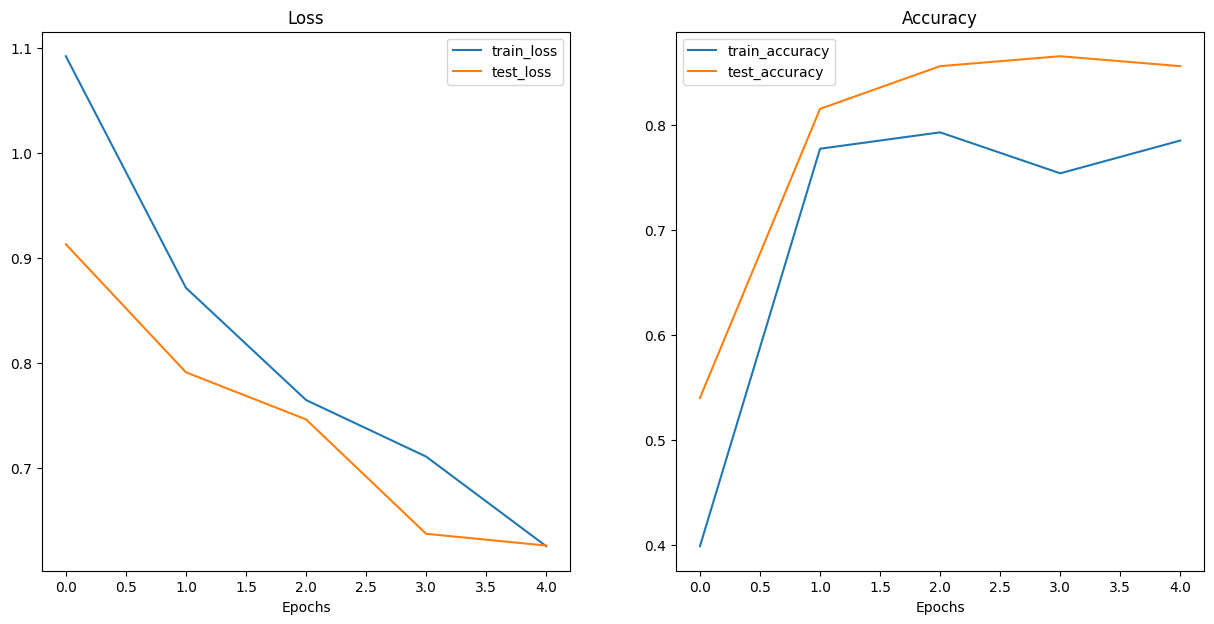

In [18]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
  from helper_functions import plot_loss_curves
except:
  print("[INFO] Couldn't find helper_functions.py, downloading...")
  with open("helper_functions.py", "wb") as f:
    import requests
    request = requests.get("https://raw.githubusercontent.com/GiX7000/deep-learning-with-pytorch/main/learn-pytorch-for-deep-learning-in-a-day/helper_functions.py") # link address with raw data
    f.write(request.content)

  from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

Those are some excellent looking loss curves!

It looks like the loss for both datasets (train and test) is heading in the right direction.

The same with the accuracy values, trending upwards.

That goes to show the power of **transfer learning**. Using a pretrained model often leads to pretty good results with a small amount of data in less time.

I wonder what would happen if you tried to train the model for longer? Or if we added more data?

> **Question:** Looking at the loss curves, does our model look like it's overfitting or underfitting? Or perhaps neither?

## 6. Make predictions on images from the test set

It looks like our model performs well quantitatively but how about qualitatively?

Let's find out by making some predictions with our model on images from the test set (these aren't seen during training) and plotting them.

*Visualize, visualize, visualize!*

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in *same* format as the images our model was trained on.

This means we'll need to make sure our images have:
* **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
* **Same datatype** - If our images are a different datatype (e.g. `torch.int8` vs. `torch.float32`) we'll get datatype errors.
* **Same device** - If our images are on a different device to our model, we'll get device errors.
* **Same transformations** - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make predictions on images transformed in a different way, these predictions may be off.

> **Note:** These requirements go for all kinds of data if you're trying to make predictions with a trained model. Data you'd like to predict on should be in the same format as your model was trained on.

To do all of this, we'll create a function `pred_and_plot_image()` to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).
3. Create a transform for the image (this will default to the `manual_transforms` we created above or it could use a transform generated from `weights.transforms()`).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

In [19]:
from typing import List, Tuple

from PIL import Image

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    ### Predict on image ###

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

Let's test it out by making predictions on a few random images from the test set.

We can get a list of all the test image paths using `list(Path(test_dir).glob("*/*.jpg"))`, the stars in the `glob()` method say "any file matching this pattern", in other words, any file ending in `.jpg` (all of our images).

And then we can randomly sample a number of these using Python's [`random.sample(population, k)`](https://docs.python.org/3/library/random.html#random.sample) where `population` is the sequence to sample and `k` is the number of samples to retrieve.

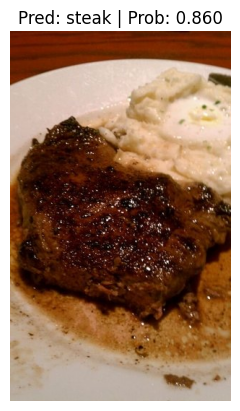

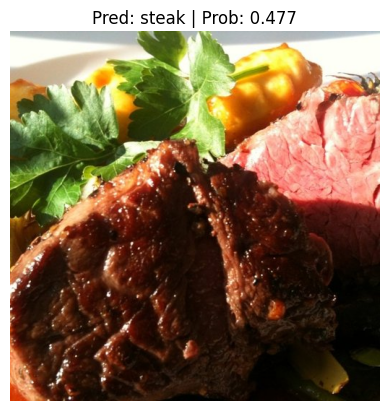

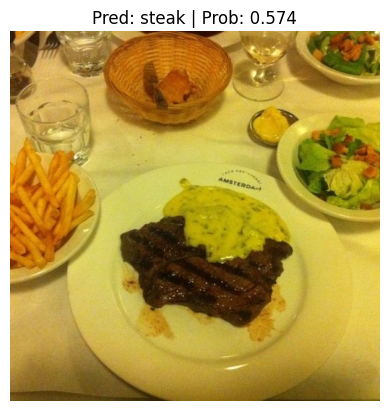

In [20]:
# Get a random list of image paths from test set
import random
num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

Those predictions look far better than the ones our TinyVGG model was previously making.

### 6.1 Making predictions on a custom image

It looks like our model does well qualitatively on data from the test set.

But how about on our own custom image?

That's where the real fun of machine learning is!

Predicting on your own custom data, outside of any training or test set.

To test our model on a custom image, let's import the old faithful `pizza-dad.jpeg` image (an image of my dad eating pizza).

We'll then pass it to the `pred_and_plot_image()` function we created above and see what happens.

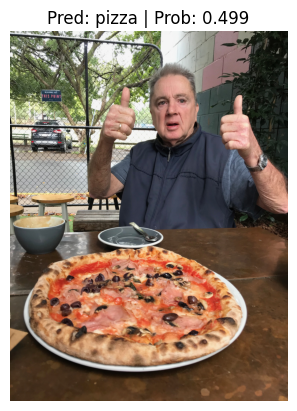

In [21]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Predict on custom image
pred_and_plot_image(model=model,
                    image_path=custom_image_path,
                    class_names=class_names)

Looks like our model got it right again!

But this time the prediction probability is higher than the one from TinyVGG (`0.373`) in previous notebook.

This indicates our `efficientnet_b0` model is *more* confident in its prediction where as our TinyVGG model was par with just guessing.

## Main takeaways
* **Transfer learning** often allows you to get good results with a relatively small amount of custom data.
* Knowing the power of transfer learning, it's a good idea to ask at the start of every problem, "does an existing well-performing model exist for my problem?"
* When using a pretrained model, it's important that your custom data be formatted/preprocessed in the same way that the original model was trained on, otherwise you may get degraded performance.
* The same goes for predicting on custom data, ensure your custom data is in the same format as the data your model was trained on.
* There are from the PyTorch domain libraries, HuggingFace Hub and libraries such as `timm` (PyTorch Image Models).

## 7. Exercises

1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels. Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [22]:
# make predictions on the entire test dataset with the above model

from tqdm.auto import tqdm

# Make predictions on the entire test dataset
test_preds = []
model.eval()
with torch.inference_mode():
  # Loop through the batches in the test dataloader
  for X, y in tqdm(test_dataloader):
    X, y = X.to(device), y.to(device)
    # Pass the data through the model
    test_logits = model(X)

    # Convert the pred logits to pred probs
    pred_probs = torch.softmax(test_logits, dim=1)

    # Convert the pred probs into pred labels
    pred_labels = torch.argmax(pred_probs, dim=1)

    # Add the pred labels to test preds list
    test_preds.append(pred_labels)

# Concatenate the test preds and put them on the CPU
test_preds = torch.cat(test_preds).cpu()
test_preds

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

In [23]:
# Get the truth labels for test dataset
test_truth = torch.cat([y for X, y in test_dataloader])
test_truth

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])

In [24]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 890.6/890.6 kB 38.0 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [25]:
# Import mlxtend upgraded version
print(mlxtend.__version__)  # should be version 0.19.0 or higher

0.23.1


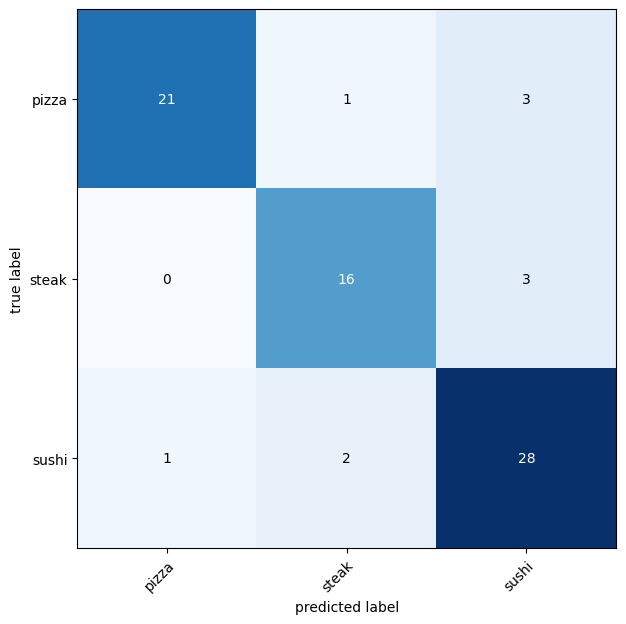

In [27]:
# create and print the confusion matrrix

from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance
confmat = ConfusionMatrix(task='multiclass', num_classes=len(class_names))
confmat_tensor = confmat(preds=test_preds,
                         target=test_truth)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names,
    figsize=(10, 7)
)

2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
    * Predicting across all of the test dataset, storing the labels and predicted probabilities.
    * Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
    * Plot the top 5 "most wrong" images, why do you think the model got these wrong?

In [29]:
# Get all test data paths
from pathlib import Path
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_labels = [path.parent.stem for path in test_data_paths]

# Create a function to return a list of dictionaries with sample, label, prediction, pred prob
def pred_and_store(test_paths, model, transform, class_names, device):
  test_pred_list = []
  for path in tqdm(test_paths):
    # Create empty dict to store info for each sample
    pred_dict = {}

    # Get sample path
    pred_dict["image_path"] = path

    # Get class name
    class_name = path.parent.stem
    pred_dict["class_name"] = class_name

    # Get prediction and prediction probability
    from PIL import Image
    img = Image.open(path) # open image
    transformed_image = transform(img).unsqueeze(0) # transform image and add batch dimension
    model.eval()
    with torch.inference_mode():
      pred_logit = model(transformed_image.to(device))
      pred_prob = torch.softmax(pred_logit, dim=1)
      pred_label = torch.argmax(pred_prob, dim=1)
      pred_class = class_names[pred_label.cpu()]

      # Make sure things in the dictionary are back on the CPU
      pred_dict["pred_prob"] = pred_prob.unsqueeze(0).max().cpu().item()
      pred_dict["pred_class"] = pred_class

    # Does the pred match the true label?
    pred_dict["correct"] = class_name == pred_class

    # print(pred_dict)
    # Add the dictionary to the list of preds
    test_pred_list.append(pred_dict)

  return test_pred_list

test_pred_dicts = pred_and_store(test_paths=test_data_paths,
                                 model=model,
                                 transform=manual_transforms,
                                 class_names=class_names,
                                 device=device)

test_pred_dicts[:5]

  0%|          | 0/75 [00:00<?, ?it/s]

[{'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/1680893.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.8098949193954468,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/3837522.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.42713063955307007,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/343036.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.4154658913612366,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/175783.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.414200097322464,
  'pred_class': 'sushi',
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi/test/sushi/1230335.jpg'),
  'class_name': 'sushi',
  'pred_prob': 0.3823283314704895,
  'pred_class': 'pizza',
  'correct': False}]

In [30]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
test_pred_df = pd.DataFrame(test_pred_dicts)
# Sort DataFrame by correct then by pred_prob
top_5_most_wrong = test_pred_df.sort_values(by=["correct", "pred_prob"], ascending=[True, False]).head()
top_5_most_wrong

image_path class_name  pred_prob  \
20   data/pizza_steak_sushi/test/sushi/684266.jpg      sushi   0.564728   
48    data/pizza_steak_sushi/test/steak/27415.jpg      steak   0.557890   
51  data/pizza_steak_sushi/test/pizza/2871261.jpg      pizza   0.529656   
74  data/pizza_steak_sushi/test/pizza/2508636.jpg      pizza   0.523417   
21  data/pizza_steak_sushi/test/sushi/2394442.jpg      sushi   0.421953   

   pred_class  correct  
20      steak    False  
48      sushi    False  
51      steak    False  
74      sushi    False  
21      pizza    False

<ipython-input-31-f856f6cfcd1b>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_path = row[0]
<ipython-input-31-f856f6cfcd1b>:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  true_label = row[1]
<ipython-input-31-f856f6cfcd1b>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pred_prob = row[2]
<ipython-input-31-f856f6cfcd1b>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, in

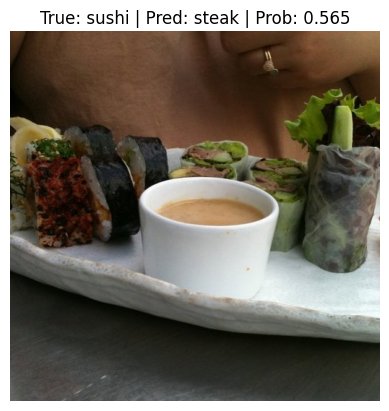

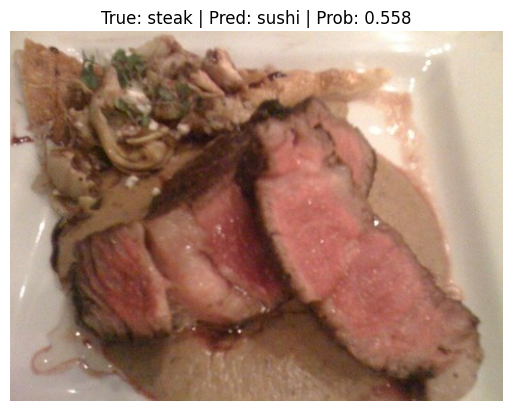

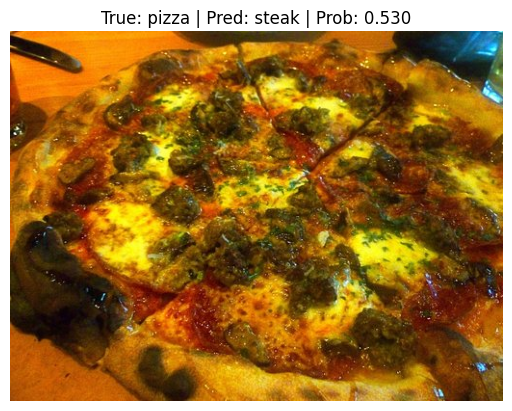

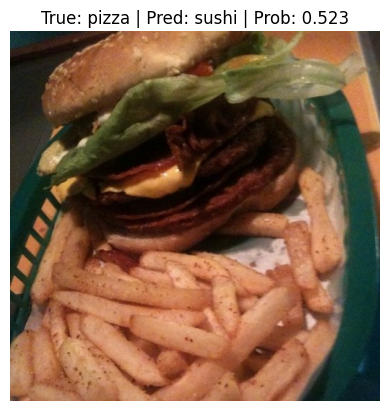

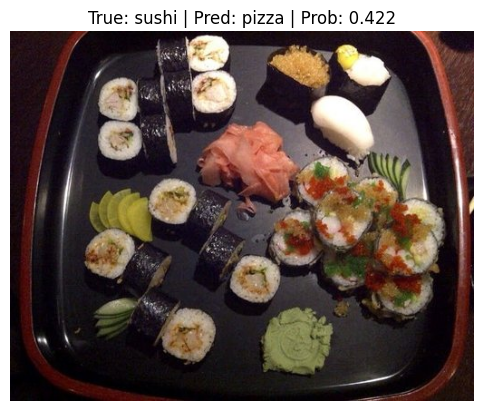

In [31]:
import torchvision
import matplotlib.pyplot as plt
# Plot the top 5 most wrong images
for row in top_5_most_wrong.iterrows():
  row = row[1]
  image_path = row[0]
  true_label = row[1]
  pred_prob = row[2]
  pred_class = row[3]
  # Plot the image and various details
  img = torchvision.io.read_image(str(image_path)) # get image as tensor
  plt.figure()
  plt.imshow(img.permute(1, 2, 0)) # matplotlib likes images in [height, width, color_channels]
  plt.title(f"True: {true_label} | Pred: {pred_class} | Prob: {pred_prob:.3f}")
  plt.axis(False);

3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?

--2024-10-27 04:40:10--  https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3208960 (3.1M) [image/jpeg]
Saving to: ‘photo-1588315029754-2dd089d39a1a’

photo-1588315029754 100%[===================>]   3.06M  --.-KB/s    in 0.02s   

2024-10-27 04:40:12 (198 MB/s) - ‘photo-1588315029754-2dd089d39a1a’ saved [3208960/3208960]



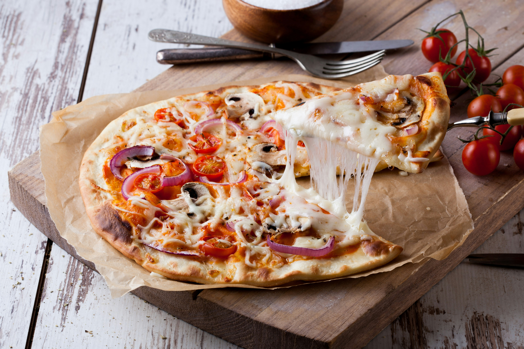

In [38]:
# Get an image of pizza/steak/sushi
!wget https://images.unsplash.com/photo-1588315029754-2dd089d39a1a
!cp photo-1588315029754-2dd089d39a1a pizza.jpg

from PIL import Image

with Image.open("pizza.jpg") as img:
  # Reduce the image size and width by 10
  (width, height) = (img.width // 10, img.height // 10)
  img_resized = img.resize((width, height))

img_resized

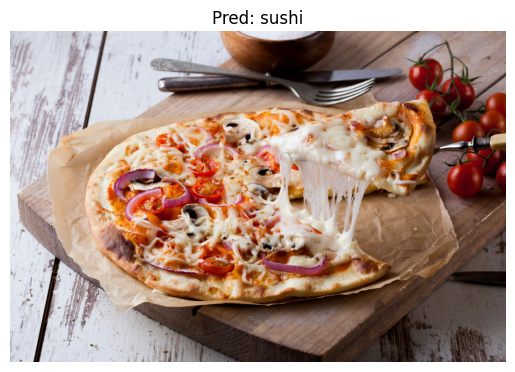

In [40]:
# Make a function to pred and plot images
def pred_and_plot(image_path, model, transform, class_names, device=device):
  # open image
  image = Image.open(image_path)

  # transform image
  transformed_image = transform(image)

  # pred on image
  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device))
    pred_label = torch.argmax(torch.softmax(pred_logit, dim=1), dim=1)

  # plot image and pred
  plt.figure()
  plt.imshow(image)
  plt.title(f"Pred: {class_names[pred_label]}")
  plt.axis(False);

pred_and_plot(image_path="pizza.jpg",
              model=model,
              transform=manual_transforms,
              class_names=class_names)

--2024-10-27 04:42:11--  https://images.unsplash.com/photo-1546964124-0cce460f38ef
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3617320 (3.4M) [image/jpeg]
Saving to: ‘photo-1546964124-0cce460f38ef.1’

photo-1546964124-0c 100%[===================>]   3.45M  --.-KB/s    in 0.02s   

2024-10-27 04:42:11 (183 MB/s) - ‘photo-1546964124-0cce460f38ef.1’ saved [3617320/3617320]



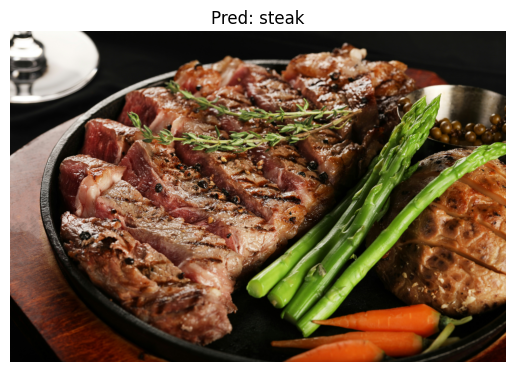

In [42]:
# Try again on a photo of steak from unsplash.com
!wget https://images.unsplash.com/photo-1546964124-0cce460f38ef
!cp photo-1546964124-0cce460f38ef steak.jpg

pred_and_plot("steak.jpg",
              model=model,
              transform=manual_transforms,
              class_names=class_names)

--2024-10-27 04:43:12--  https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
Resolving images.unsplash.com (images.unsplash.com)... 151.101.2.208, 151.101.66.208, 151.101.130.208, ...
Connecting to images.unsplash.com (images.unsplash.com)|151.101.2.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2006529 (1.9M) [image/jpeg]
Saving to: ‘photo-1570913149827-d2ac84ab3f9a’

photo-1570913149827 100%[===================>]   1.91M  --.-KB/s    in 0.01s   

2024-10-27 04:43:12 (169 MB/s) - ‘photo-1570913149827-d2ac84ab3f9a’ saved [2006529/2006529]



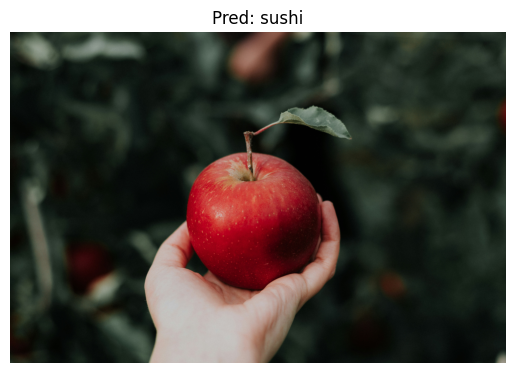

In [43]:
# Get an image of not pizza/steak/sushi
!wget https://images.unsplash.com/photo-1570913149827-d2ac84ab3f9a
!cp photo-1570913149827-d2ac84ab3f9a apple.jpg

pred_and_plot(image_path="apple.jpg",
              model=model,
              transform=manual_transforms,
              class_names=class_names)

4. Train the model from section 4 above for longer (10 epochs should do), what happens to the performance?

In [44]:
# Recreate a new model
import torchvision
from torch import nn
model_1 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze the base layers
for param in model_1.features.parameters():
  param.requires_grad = False

# Change the classification head
torch.manual_seed(42)
model_1.classifier = torch.nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
).to(device)

# summary(model_1,
#         input_size=[32, 3, 224, 224],
#         col_names=["input_size", "output_size", "trainable"])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [45]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Create loss and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

# Setup training and save the results
model_1_results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.5785 | train_acc: 0.8945 | test_loss: 0.5743 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5263 | train_acc: 0.9102 | test_loss: 0.5470 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5226 | train_acc: 0.8008 | test_loss: 0.5291 | test_acc: 0.8665
Epoch: 9 | train_loss: 0.5671 | train_acc: 0.8125 | test_loss: 0.5076 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.4847 | train_acc: 0.8203 | test_loss: 0.4400 | test_acc: 0.9062
[INFO] Total training time: 28.085 seconds


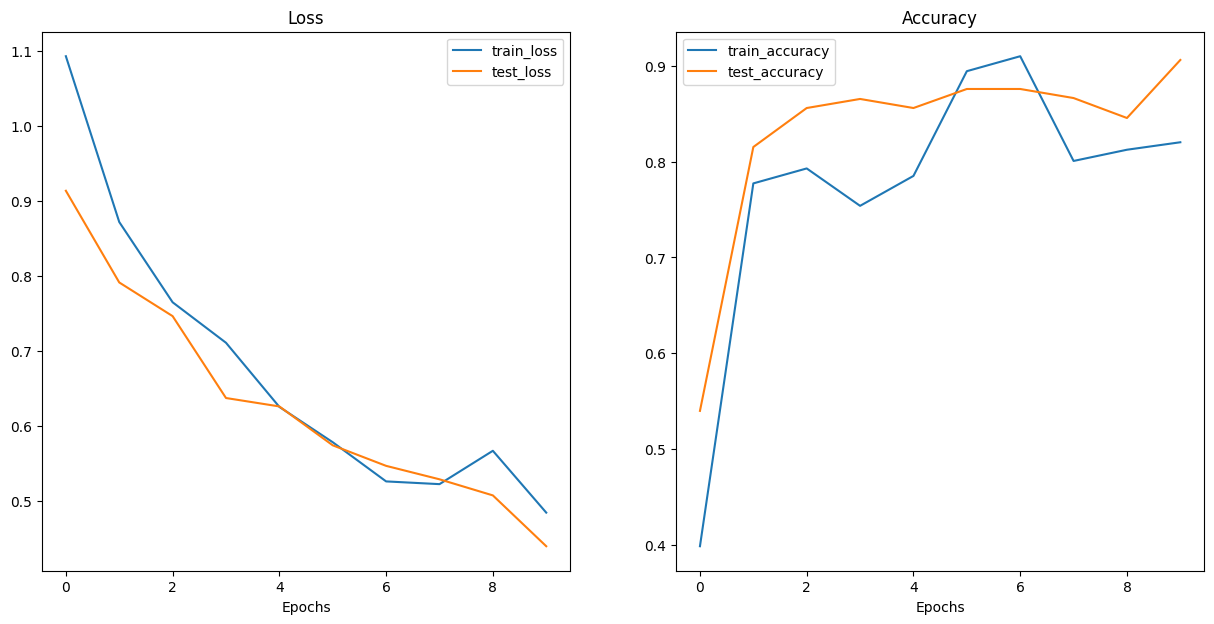

In [46]:
# Plot the loss curves of our model
plot_loss_curves(model_1_results)

If we train for longer, it looks like we get slightly lower loss and potentially higher accuracy but our model starts to look like it overfits if we train for too long.

Potentially data augmentation or a learning rate decay (lowering the learning rate over time) can help to prevent overfitting.

5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
    * You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).

In [47]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

In [48]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [49]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7e5c10f48af0>,
 ['pizza', 'steak', 'sushi'])

In [51]:
len(train_dataloader), len(test_dataloader), len(train_dataloader_20_percent), len(test_dataloader_20_percent)

(8, 3, 15, 5)

In [52]:
# Create a new model for 20 percent of the data
model_2 = torchvision.models.efficientnet_b0(pretrained=True).to(device)

# Freeze all the base layers
for param in model_2.features.parameters():
  param.requires_grad = False

# Change the classifier head
torch.manual_seed(42)
model_2.classifier = nn.Sequential(
  nn.Dropout(p=0.2, inplace=True),
  nn.Linear(in_features=1280, out_features=3, bias=True)
).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [53]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_2_results = engine.train(model=model_2,
                              train_dataloader=train_dataloader_20_percent,
                              test_dataloader=test_dataloader_20_percent,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9747 | train_acc: 0.5667 | test_loss: 0.6472 | test_acc: 0.8949
Epoch: 2 | train_loss: 0.7067 | train_acc: 0.8167 | test_loss: 0.5291 | test_acc: 0.9006
Epoch: 3 | train_loss: 0.5866 | train_acc: 0.8271 | test_loss: 0.4519 | test_acc: 0.8881
Epoch: 4 | train_loss: 0.4555 | train_acc: 0.8917 | test_loss: 0.4089 | test_acc: 0.8881
Epoch: 5 | train_loss: 0.4520 | train_acc: 0.8896 | test_loss: 0.3788 | test_acc: 0.9068
[INFO] Total training time: 16.513 seconds


In [55]:
# Check results with 10% of data for 5 epochs
max(results["test_acc"]), min(results["test_loss"])

(0.8655303030303031, 0.6261006395022074)

In [56]:
# Check results with 20% of data for 5 epochs
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.9068181818181819, 0.3788063287734985)

6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
    * You'll have to change the size of the classifier layer to suit our problem.
    * You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?

In [57]:
# Create a transform to transform the data
from torchvision import transforms, models
effnet_b2_transform = transforms.Compose([
  transforms.Resize((288, 288)), # effnet_b2 takes images of size 288, 288 - https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [58]:
# Use 10% data sample for effnet_b2 to compare to model 0(initial model) results
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [59]:
# Import the data
train_dataloader_effnet_b2, test_dataloader_effnet_b2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                   test_dir=test_dir,
                                                                                                   transform=effnet_b2_transform,
                                                                                                   batch_size=32)

In [60]:
# Create a effnet_b2 new model - https://pytorch.org/vision/stable/generated/torchvision.models.efficientnet_b2.html#torchvision.models.efficientnet_b2
model_3 = torchvision.models.efficientnet_b2(pretrained=True).to(device)

# Freeze the base layers
for param in model_3.parameters():
  param.requires_grad = False

# Change the classifier head (to suit our problem)
torch.manual_seed(42)
model_3.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, out_features=len(class_names), bias=True)
).to(device)

# Get a summary of the new model
# summary(model_3,
#         input_size=[32, 3, 288, 288],
#         col_names=["input_size", "output_size", "trainable"])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 103MB/s]


In [61]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_3_results = engine.train(model=model_3,
                              train_dataloader=train_dataloader_effnet_b2,
                              test_dataloader=test_dataloader_effnet_b2,
                              optimizer=optimizer,
                              loss_fn=loss_fn,
                              epochs=5,
                              device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.1112 | train_acc: 0.3242 | test_loss: 0.9117 | test_acc: 0.7027
Epoch: 2 | train_loss: 0.8985 | train_acc: 0.6719 | test_loss: 0.8660 | test_acc: 0.8352
Epoch: 3 | train_loss: 0.8051 | train_acc: 0.8008 | test_loss: 0.7908 | test_acc: 0.8456
Epoch: 4 | train_loss: 0.7409 | train_acc: 0.7695 | test_loss: 0.6717 | test_acc: 0.9280
Epoch: 5 | train_loss: 0.6484 | train_acc: 0.8047 | test_loss: 0.6559 | test_acc: 0.8769
[INFO] Total training time: 13.351 seconds


Experiments:

model_0 = 10% data, effnet_b0, 5 epochs

model_1 = 10% data, effnet_b0, 10 epochs (double training time)

model_2 = 20% data, effnet_b0, 5 epochs (double data)

model_3 = 10% data, effnet_b2, 5 epochs (double model parameters)

In [62]:
# Check effnet_b0 results with 10% of data for 5 epochs
max(results["test_acc"]), min(results["test_loss"])

(0.8655303030303031, 0.6261006395022074)

In [63]:
# Check effnet_b0 results with 10% of data for 10 epochs (double training time)
max(model_1_results["test_acc"]), min(model_1_results["test_loss"])

(0.90625, 0.43997153639793396)

In [64]:
# Check effnet_b0 results with 20% of data for 5 epochs (double data)
max(model_2_results["test_acc"]), min(model_2_results["test_loss"])

(0.9068181818181819, 0.3788063287734985)

In [65]:
# Check effnet_b2 results with 10% of data for 5 epochs (double model parameters)
max(model_3_results["test_acc"]), min(model_3_results["test_loss"])

(0.9280303030303031, 0.6558907429377238)